In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, Subset

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
class STSDataset(Dataset):
    def __init__(self, annotations_file, num_classes, 
                 transform=None, target_transform=None):
        self.sts_annotations = pd.read_csv(annotations_file)
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform
        self.sts_len = 0

    def __len__(self):
        return len(self.sts_annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get annotation data for current indicies
#         sts_path = os.path.join(self.root_dir, self.sts_annotations.iloc[idx, 0])
        sts_path = self.sts_annotations['files'][idx]
    #         label = self.sts_annotations.iloc[idx, 1]
        label = self.sts_annotations['category'][idx]
        label_onehot = np.zeros(self.num_classes)
        label_onehot[label] = 1
    
        # Read STS data from disk
        sts_df = pd.read_csv(sts_path,
                     sep="\s+",
                     skiprows=10, 
                     usecols=[3], 
                     names=['dI/dV (A/V)'])
                
        # Standardize features by removing the mean and scaling to unit variance 
        # Then, the sts data will have standard, normal distribution
        # (e.g. Gaussian with 0 mean and unit variance).
        scaler_std = StandardScaler()
        sts_std = scaler_std.fit_transform(sts_df).flatten()
#          sts_std = sts_df['dI/dV (A/V)']
        n = len(sts_std)
        if self.sts_len == 0:
            self.sts_len = n
        elif self.sts_len != n:
            if self.sts_len < n:
                sts_std = sts_std[:self.sts_len]
#                 print(len(sts_std))
            else:
                z = np.zeros(self.sts_len - n, dtype=float)
                sts_std = np.concatenate((sts_std,z))
#                 print(len(sts_std))
        
        if self.transform:
            sts_std = self.transform(sts_std)
        if self.target_transform:
            label_onehot = self.target_transform(label_onehot)
            
        sample = {"sts": torch.tensor(sts_std, dtype=float), "label": label_onehot}
        return torch.tensor(sts_std), label_onehot

In [7]:
## *NOTE: Voltage sweep for all STS data is from high to low.

In [8]:
# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability 
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

Torch device selected:  cuda


In [4]:
labels_df = pd.read_csv('H:/Research/AI_STM/sts-storage/dpath/annotations.csv')
labels_df['files'][[0,1,2,3,]]

0    H:/Research/AI_STM/sts-storage/dpath/Au\dI_dV0...
1    H:/Research/AI_STM/sts-storage/dpath/Au\dI_dV0...
2    H:/Research/AI_STM/sts-storage/dpath/Au\dI_dV0...
3    H:/Research/AI_STM/sts-storage/dpath/Au\dI_dV0...
Name: files, dtype: object

In [5]:
# Create transformations to apply to each data sample 
# Can specify variations such as image flip, color flip, random crop, ...
transform=transforms.Compose([
    transforms.Resize((1,1200)),
    ])

In [6]:
sts_dataset = STSDataset(annotations_file='H:/Research/AI_STM/sts-storage/dpath/annotations.csv',
                        num_classes=2)

0 torch.Size([1200]) [1. 0.]
1 torch.Size([1200]) [1. 0.]
2 torch.Size([1200]) [1. 0.]
3 torch.Size([1200]) [1. 0.]


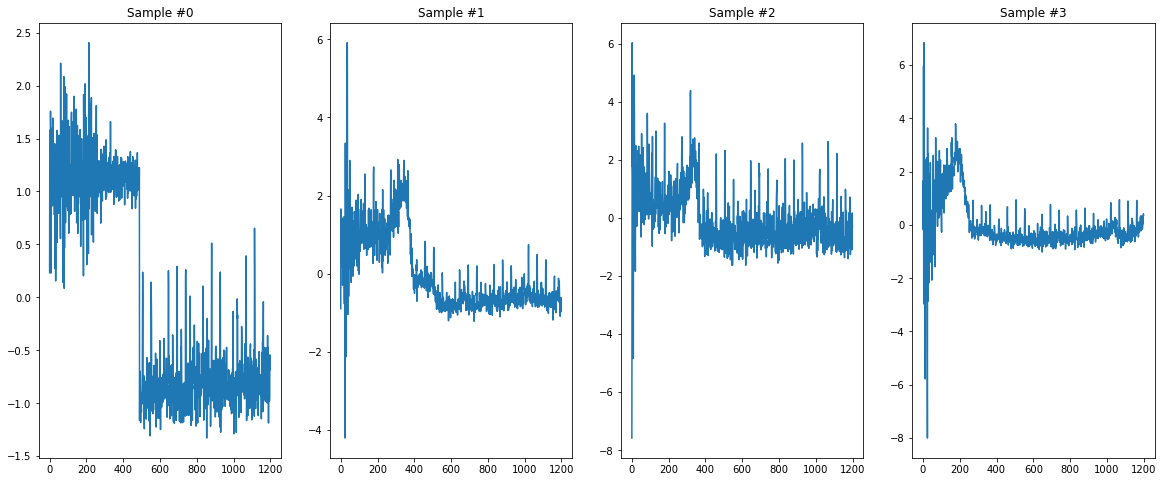

In [7]:
fig = plt.figure(figsize=(20,8))

for i in range(len(sts_dataset)):
    sts, label = sts_dataset[i]
    print(i, sts.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    ax.set_title('Sample #{}'.format(i))
    sample = sts.numpy()
    plt.plot(sample)

    if i == 3:
        plt.show()
        break

# Create train and val subsets

In [8]:
idxs = list(range(len(sts_dataset)))
test_split = 0.3
val_split = 0.3
train_idx, test_idx = train_test_split(idxs, test_size=test_split)
train_idx, val_idx = train_test_split(train_idx, test_size=val_split)
sts_train_dataset = Subset(sts_dataset, train_idx)
sts_val_dataset = Subset(sts_dataset, val_idx)
sts_test_dataset = Subset(sts_dataset, test_idx)

# Preparing data for training with DataLoaders

In [9]:
train_dataloader = DataLoader(sts_train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(sts_val_dataset, batch_size=16, shuffle=True)
test_dataloder = DataLoader(sts_test_dataset, batch_size=16, shuffle=False)

### Test iteration through the DataLoader

In [10]:
sts, label = next(iter(train_dataloader))
sts_train_dataset[0]

(tensor([4.8175, 4.7111, 4.6784,  ..., 4.4837, 4.5361, 4.5462],
        dtype=torch.float64),
 array([0., 1.]))

# Define Neural Network

In [11]:
class Network(nn.Module):

    def __init__(self, n, m, debug=False):
        super().__init__()
        self.debug = debug
        self.fc1 = nn.Linear(n, 64)
        self.b1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64,128)
        self.b2 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128,m)

    def forward(self,x):

        x = F.relu(self.fc1(x))
        x = self.b1(x)
        x = F.relu(self.fc2(x))
        x = self.b2(x)
        x = self.d1(x)
        x = torch.sigmoid(self.fc3(x))
        
        # Remove unnecessary dimensions and change shape to match target tensor
        # [BATCH_SIZE, num_classes, 1, 1] --> [BATCH_SIZE,num_classes] to make predicitons
        output = torch.squeeze(x)
        if self.debug: print("output:\t", output.shape)

        return x

# Train Network

In [12]:
def progbar(curr, total, full_progbar, accuracy):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', 
          '#'*filled_progbar + '-'*(full_progbar-filled_progbar), 
          '[{:>7.2%}]'.format(frac), 
          'Accuracy: [{:>7.2%}]'.format(accuracy),
          end='')

In [13]:
def train(model, device, train_loader, optimizer, criterion, epoch, batch_size, num_cats):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    correct = 0
    
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        
        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data.float())
        
        # Compute loss based on criterion
        loss = criterion(output.float(), target.float())

        # Computes gradient based on final loss
        loss.backward()
        
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()

        # Get predicted class by rounding 
        pred = output.round()
        # Count correct predictions overall 
        # Get element-wise equality between the preds and the targets for this batch,
        # finally sum the equalities and convert to a python float
        n_equal = pred.eq(target).sum().item()
        correct += n_equal

        if model.debug: 
            batch_accuracy = n_equal / torch.numel(target)
            progbar(batch_idx, len(train_loader), 10, batch_accuracy)
    
    train_loss = float(np.mean(losses))
    train_acc = 100. * correct / ((batch_idx+1) * batch_size * num_cats)
    
    print('\nTrain set\t Average loss: {:.4f}\t Average Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, (batch_idx+1) * batch_size * num_cats, train_acc))
          
    return train_loss, train_acc

In [14]:
def test(model, device, test_loader, criterion, num_cats):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
                
            # Predict for data by doing forward pass
            output = model(data.float())
            
            # Compute loss based on same criterion as training
            loss = criterion(output.float(), target.float())

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted class by rounding 
            pred = output.round()
            # Count correct predictions overall 
            # Get element-wise equality between the preds and the targets for this batch,
            # finally sum the equalities and convert to a std python float
            n_equal = pred.eq(target).sum().item()
            correct += n_equal

    test_loss = float(np.mean(losses))
    test_acc = (100. * correct) / (len(test_loader.dataset) * num_cats)
    print('Test set\t Average loss: {:.4f}\t Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset) * num_cats, test_acc))
    
    return test_loss, test_acc

In [15]:
num_classes = 2
n = len(sts_dataset[0][0])
model = Network(n=n, m=num_classes, debug=False).to(device)
EPOCHS = 10
learning_rate = 0.001
BATCH_SIZE = 16
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
best_accuracy = 0.0
train_losses = np.zeros(EPOCHS)
train_accuracies = np.zeros(EPOCHS)
val_losses = np.zeros(EPOCHS)
val_accuracies = np.zeros(EPOCHS)

In [17]:
for epoch in range(1, EPOCHS + 1):
    print("Epoch {}".format(epoch))
    train_loss, train_accuracy = train(model, device, 
                                           train_dataloader, 
                                           optimizer, criterion, 
                                           epoch, BATCH_SIZE, 
                                           num_classes)
    val_loss, val_accuracy = test(model, device, 
                                    val_dataloader, 
                                    criterion, num_classes)

    # Store epoch metrics in memory
    i = epoch - 1
    train_losses[i] = train_loss
    train_accuracies[i] = train_accuracy
    val_losses[i] = val_loss
    val_accuracies[i] = val_accuracy

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        
# Print final results to console
print("best accuracy was {:2.2f}".format(best_accuracy))
print("Training and evaluation finished")

Epoch 1

Train set	 Average loss: 0.2228	 Average Accuracy: 946/1024 (92%)
Test set	 Average loss: 0.0451	 Accuracy: 432/432 (100%)
Epoch 2

Train set	 Average loss: 0.0425	 Average Accuracy: 1003/1024 (98%)
Test set	 Average loss: 0.0157	 Accuracy: 432/432 (100%)
Epoch 3

Train set	 Average loss: 0.0237	 Average Accuracy: 1002/1024 (98%)
Test set	 Average loss: 0.0077	 Accuracy: 432/432 (100%)
Epoch 4

Train set	 Average loss: 0.0147	 Average Accuracy: 1006/1024 (98%)
Test set	 Average loss: 0.0073	 Accuracy: 432/432 (100%)
Epoch 5

Train set	 Average loss: 0.0111	 Average Accuracy: 1006/1024 (98%)
Test set	 Average loss: 0.0025	 Accuracy: 432/432 (100%)
Epoch 6

Train set	 Average loss: 0.0214	 Average Accuracy: 1000/1024 (98%)
Test set	 Average loss: 0.0019	 Accuracy: 432/432 (100%)
Epoch 7

Train set	 Average loss: 0.0224	 Average Accuracy: 1002/1024 (98%)
Test set	 Average loss: 0.0022	 Accuracy: 432/432 (100%)
Epoch 8

Train set	 Average loss: 0.0094	 Average Accuracy: 1006/1024 

In [18]:
def plot_metrics(metrics):
    plt.figure(figsize=(16, 12))
    for n, metric in enumerate(['loss', 'accuracy']):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(metrics[metric], label='Train')
        plt.plot(metrics['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.autoscale()
        plt.legend()
        plt.title("Standardized Data")
        
    plt.autoscale()
    plt.legend()

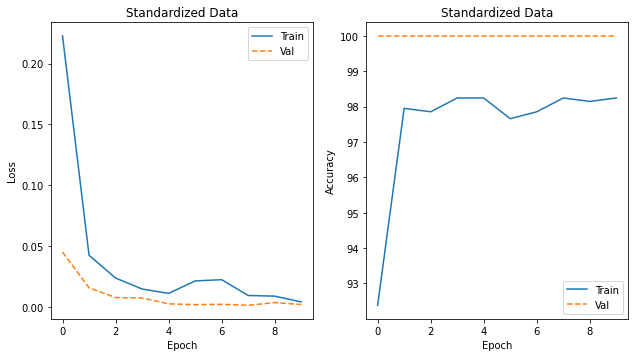

In [19]:
plot_metrics({
    "loss": train_losses, 
    "accuracy": train_accuracies, 
    "val_loss": val_losses, 
    "val_accuracy": val_accuracies
})

# Evalutate Model Predictions

In [24]:
def make_predictions(model, device, test_loader):
    # Set model to eval mode to notify all layers.
    model.eval()
    
    targets = []
    preds = []
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            
            # Predict for data by doing forward pass
            output = model(data.float())
            pred = torch.round(output)
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
            
    targets = [np.hstack(y) for y in targets]
    preds = [np.hstack(y) for y in preds]
    
    targets = np.hstack(targets)
    preds = np.hstack(preds)
    
    return targets, preds

In [25]:
y_true_baseline, y_pred_baseline = make_predictions(model, device, train_dataloader)

In [26]:
y_true, y_pred = make_predictions(model, device, test_dataloder)

In [ ]:
# y_true = [np.hstack(y) for y in y_true]
# y_pred = [np.hstack(y) for y in y_pred]

In [ ]:
# y_true = np.hstack(y_true)
# y_pred = np.hstack(y_pred)

In [27]:
print(len(y_true))
print(len(y_pred))
# Need to account for the [nx2] target vs the torch.max [nx1] pred.  

618
618


In [28]:
def plot_cm(labels, predictions, p=0.5, num_classes=2):
    cm = confusion_matrix(labels, predictions, labels=range(num_classes))
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Fraudulent: ', np.sum(cm[1]))

True Negatives:  309
False Positives:  0
False Negatives:  0
True Positives:  309
Total Fraudulent:  309


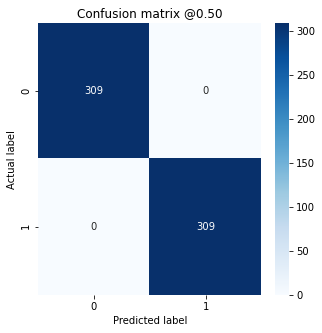

In [29]:
plot_cm(y_true, y_pred, num_classes=2)

## Plot the ROC
Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [35]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [36]:
from itertools import cycle
def plot_roc_multiclass(name, labels, predictions, **kwargs):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 2
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        y_test = (labels == i).astype(int)
        y_pred = (predictions == i).astype(int)
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test, y_pred)
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
#         roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr[i], tpr=tpr[i]).plot()
    
    lw = 2
    colors = cycle(['blue', 'red', 'green', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='No Skill')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (%)')
    plt.ylabel('True Positive Rate (%)')
    plt.title('Receiver operating characteristic for {} data'.format(name))
    plt.legend(loc="lower right")
    plt.gca().set_aspect('equal')
    plt.show()

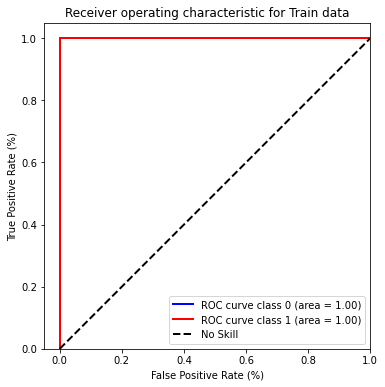

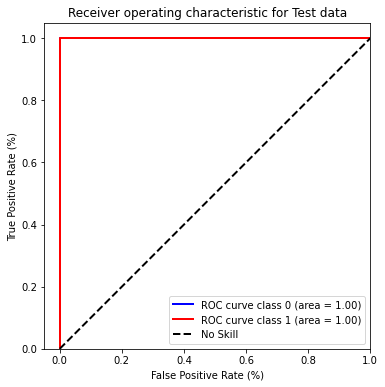

In [37]:
plot_roc_multiclass("Train", y_true_baseline, y_pred_baseline)
plot_roc_multiclass("Test", y_true,  y_pred, linestyle='--')

In [38]:
from sklearn.metrics import precision_recall_curve

def plot_pr_multiclass(name, labels, predictions, **kwargs):
    precision = dict()
    recall = dict()
    thresholds = dict()
    mAP = dict()
    n_classes = 2
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        y_test = (labels == i).astype(int)
        y_pred = (predictions == i).astype(int)
        precision[i], recall[i], thresholds[i] = sklearn.metrics.precision_recall_curve(y_test, y_pred)
        mAP[i] = sklearn.metrics.average_precision_score(y_test, y_pred)
#         pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=precision[i], recall=recall[i]).plot()
        
    lw = 2
    colors = cycle(['blue', 'red', 'green', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=lw,
                 label='Percision-Recall curve class {0} (mAP = {1:0.2f})'.format(i, mAP[i]))

    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linestyle='--', label='No Skill')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Percision')
    plt.title('Percision-Recall Curve for {} data'.format(name))
    plt.legend(loc="upper right")
    plt.gca().set_aspect('equal')
    plt.show()

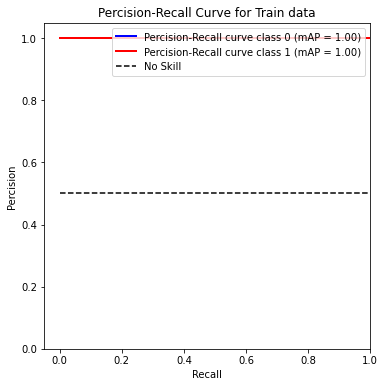

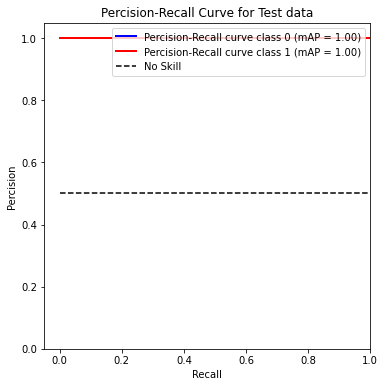

In [39]:
plot_pr_multiclass("Train",  y_true_baseline, y_pred_baseline)
plot_pr_multiclass("Test",  y_true,  y_pred, linestyle='--')

# Explore synthetic S vacancy in WS2 STS map with drift compensation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [5]:
STS_ann = np.load('G:/Research/AI_STM/sts-storage/dpath/STS-cube_annotations.npy')
STS_ann.shape

(128, 128)

In [6]:
STS = np.load('G:/Research/AI_STM/sts-storage/dpath/testdataVacancy_full.npy')
STS.shape

(128, 128, 1200)

In [8]:
# X = STS.flatten()
X = STS.reshape(-1, 1200)
X.shape

(16384, 1200)

In [ ]:
# Estimate bandwith
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Fit Mean Shift with Scikit
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(X)
labels = meanshift.labels_
cluster_centers = meanshift.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

In [60]:
k_means = KMeans(n_clusters=3)
k_means.fit(X)
k_labels = k_means.labels_
k_cluster_centers = k_means.cluster_centers_

k_labels_unique = np.unique(labels)
k_n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % k_n_clusters_)

number of estimated clusters : 2


<ipython-input-60-4bd7a7bf5c3e>:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  k_means.fit(X)


In [29]:
import pickle
# save the model to disk
filename = 'mean-shift_model.sav'
pickle.dump(meanshift, open(filename, 'wb'))

In [30]:
# Predict the cluster for all the samples
P = meanshift.predict(X)

In [62]:
# Predict the cluster for all the samples
P = k_means.predict(X)

In [66]:
# Generate scatter plot for training data
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426' if x == 2 else '#67c614', P))
plt.scatter(X[:], c=colors, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.xlabel('Voltage')
plt.ylabel('dI/dV')
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(k_n_clusters_), colors):
    my_members = labels == k
    cluster_center = k_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(k_cluster_centers[0], k_cluster_centers[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

In [ ]:
sts_dataset = STSDataset(annotations_file='H:/Research/AI_STM/sts-storage/dpath/annotations.csv',
                        num_classes=2)

In [ ]:
class STSDataset(Dataset):
    def __init__(self, annotations_file, num_classes, 
                 transform=None, target_transform=None):
        self.sts_annotations = pd.read_csv(annotations_file)
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform
        self.sts_len = 0

    def __len__(self):
        return len(self.sts_annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get annotation data for current indicies
#         sts_path = os.path.join(self.root_dir, self.sts_annotations.iloc[idx, 0])
        sts_path = self.sts_annotations['files'][idx]
    #         label = self.sts_annotations.iloc[idx, 1]
        label = self.sts_annotations['category'][idx]
        label_onehot = np.zeros(self.num_classes)
        label_onehot[label] = 1
    
        # Read STS data from disk
        sts_df = pd.read_csv(sts_path,
                     sep="\s+",
                     skiprows=10, 
                     usecols=[3], 
                     names=['dI/dV (A/V)'])
                
        # Standardize features by removing the mean and scaling to unit variance 
        # Then, the sts data will have standard, normal distribution
        # (e.g. Gaussian with 0 mean and unit variance).
        scaler_std = StandardScaler()
        sts_std = scaler_std.fit_transform(sts_df).flatten()
#          sts_std = sts_df['dI/dV (A/V)']
        n = len(sts_std)
        if self.sts_len == 0:
            self.sts_len = n
        elif self.sts_len != n:
            if self.sts_len < n:
                sts_std = sts_std[:self.sts_len]
#                 print(len(sts_std))
            else:
                z = np.zeros(self.sts_len - n, dtype=float)
                sts_std = np.concatenate((sts_std,z))
#                 print(len(sts_std))
        
        if self.transform:
            sts_std = self.transform(sts_std)
        if self.target_transform:
            label_onehot = self.target_transform(label_onehot)
            
        sample = {"sts": torch.tensor(sts_std, dtype=float), "label": label_onehot}
        return torch.tensor(sts_std), label_onehot